#  clusterpy requires python2 

In [65]:
import numpy as np
import pandas as pd
import geopandas as gpd

import pysal.contrib.clusterpy as cp
import pysal as ps
from pysal.weights import Queen, KNN

import matplotlib.pyplot as plt

%load_ext watermark
%watermark
%matplotlib inline

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
2018-02-02T23:08:35

CPython 2.7.14
IPython 5.5.0

compiler   : GCC 4.2.1 Compatible Apple LLVM 6.1.0 (clang-602.0.53)
system     : Darwin
release    : 17.4.0
machine    : x86_64
processor  : i386
CPU cores  : 8
interpreter: 64bit


## Data prep

In [66]:
# ensure geoid is read as string to preserve leading 0
attrs = pd.read_csv('data/la_data.csv', converters={'geoid': str}) 
attrs.set_index('geoid', inplace=True)
shp = gpd.GeoDataFrame.from_file('data/la_msa.shp') # need to reinitialize as Geodataframe

In [67]:
# make sure geo and attribute data are in same order to avoid linking weights by ID
attrs.sort_index(inplace=True)
shp.set_index('GEOID', inplace=True)
shp.sort_index(inplace=True)

In [68]:
shp.head()

,geometry
GEOID,
06037101110,POLYGON ((-118.2979312137039 34.26322687612055...
06037101122,POLYGON ((-118.2774342104291 34.25990787645111...
06037101210,POLYGON ((-118.2859362111909 34.25589987630816...
06037101220,POLYGON ((-118.2849922110132 34.25589387633028...
06037101300,POLYGON ((-118.2652762074589 34.25238487698516...


In [69]:
attrs.head()

,pct_bachelor_or_greater,pct_white,pct_black,pct_hispanic,pct_asian,pct_minority,median_household_income,median_home_value
geoid,,,,,,,,
06037101110,0.219321,0.556799,0.014519,0.337065,0.084603,0.443201,0.161688,0.182312
06037101122,0.307796,0.752355,0.005149,0.123974,0.106005,0.247645,0.400201,0.253920
06037101210,0.187990,0.417035,0.037836,0.487759,0.016538,0.582965,0.114613,0.154875
06037101220,0.224474,0.538939,0.023357,0.259132,0.156818,0.461061,0.121456,0.181005
06037101300,0.351540,0.788662,0.009991,0.103855,0.099898,0.211338,0.288696,0.228493




`attrs` contains several important tract-level demographic variables from the LTDB database (constructed from https://github.com/knaaptime/tstracts). Currently the data are a timeseries in long-form, so each tract is represented in the dataset 5 times: once each for for 1980, 1990, 2000, 2010, and 2015. Ignoring the temporal dimension for now, we'll use only the 2015 data for a subset of the attributes: race, income, education, and housing price

In [70]:
# use this method to build neighbor matrix directly from shapefile
# building from pandas uses the dataframe index to join observations w/ neighbors and ps.region doesn't understand

w = ps.queen_from_shapefile('data/la_msa.shp')

In [6]:
#W = Queen.from_dataframe(shp)
#K = KNN.from_dataframe(shp, k=5)

In [8]:
# clusterpy needs a gal file
fo = ps.open('data/la.gal', 'w')
fo.write(w)
fo.close()

## Clusterpy Algorithms

### AZP

In [71]:
# for storing the results
la = shp.copy()
clusters = pd.DataFrame()

In [72]:
%%time
azp = cp.Layer()
cp.addArray2Layer(attrs.values, azp, names=attrs.columns.tolist())
cp.addQueen2Layer('data/la.gal', azp)
azp.cluster('azp', attrs.columns.tolist(), 15, wType='queen')

Adding variables
Done
Adding variables
Done
Adding variables
Done
Adding variables
Done
Adding variables
Done
Adding variables
Done
Adding variables
Done
Adding variables
Done
Getting variables
Variables successfully extracted
Running original AZP algorithm (Openshaw and Rao, 1995)
Number of areas:  2779
Number of regions:  15
Constructing regions
initial Solution:  [6, 6, 6, 6, 6, 6, 6, 6, 9, 6, 6, 6, 6, 6, 6, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 6, 9, 6, 6, 6, 6, 6, 9, 9, 9, 9, 6, 6, 6, 6, 6, 6, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 9, 9, 9, 6, 6, 6, 6, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 6, 9, 9, 9, 6, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 6, 9, 9, 9, 6, 6, 6, 6, 6, 9, 6, 6, 6, 9, 9, 9, 9, 9, 9, 9, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 

FINAL SOLUTION:  [6, 6, 6, 6, 6, 6, 6, 6, 9, 6, 6, 6, 6, 6, 6, 9, 9, 9, 6, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 6, 9, 6, 6, 6, 6, 6, 9, 9, 9, 9, 6, 6, 6, 6, 6, 6, 9, 6, 6, 9, 9, 9, 9, 9, 6, 9, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 9, 9, 9, 6, 6, 6, 6, 6, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 6, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 6, 9, 9, 9, 6, 9, 9, 9, 6, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 6, 9, 6, 9, 9, 9, 6, 6, 6, 6, 6, 6, 6, 7, 6, 9, 9, 9, 9, 9, 9, 9, 7, 6, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 9, 9, 9, 9, 6, 9, 9, 9, 9, 9, 6, 9, 9, 6, 9, 9, 9, 9, 6, 9, 9, 6, 9, 6, 6, 6, 7, 7, 6, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 6, 6, 6, 6, 7, 6, 6, 7, 6, 7, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 7, 6, 6, 6, 7, 7, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7

In [73]:
clusters['azp'] = azp.region2areas
clusters.to_csv('data/clusters.csv')


### AZPSA

In [74]:
%%time
azpsa = cp.Layer()
cp.addArray2Layer(attrs.values, azpsa, names=attrs.columns.tolist())
cp.addQueen2Layer('data/la.gal', azpsa)
azpsa.cluster('azpSa', attrs.columns.tolist(), 15, wType='queen')


Adding variables
Done
Adding variables
Done
Adding variables
Done
Adding variables
Done
Adding variables
Done
Adding variables
Done
Adding variables
Done
Adding variables
Done
Getting variables
Variables successfully extracted
Running original AZP-SA algorithm (Openshaw and Rao, 1995)
Number of areas:  2779
Number of regions:  15
Boltzmann's equation: 
     R(0,1) < exp((-(Candidate Soution - Current Solution) / Current Solution)/T(k))
Cooling schedule: T(k) = 0.85 T(k-1)
initial solution:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 6, 6, 6, 6, 6, 6, 6, 6, 1, 6, 1, 1, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

FINAL SOLUTION:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 6, 6, 6, 6, 6, 6, 6, 6, 1, 6, 1, 1, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 6, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 10, 6, 6, 6, 6, 10, 6, 6, 6, 6, 10, 10, 6, 6, 6, 6, 6, 6, 10, 6, 6, 10, 10, 10, 10, 10, 10, 10, 1, 1, 1

In [75]:
clusters['azpsa'] = azpsa.region2areas
clusters.to_csv('data/clusters.csv')

### SOM

In [76]:
%%time
som = cp.Layer()
cp.addArray2Layer(attrs.values, som, names=attrs.columns.tolist())
cp.addQueen2Layer('data/la.gal', som)
som.cluster('som', attrs.columns.tolist(), nRows=3,nCols=3, wType='queen')

Adding variables
Done
Adding variables
Done
Adding variables
Done
Adding variables
Done
Adding variables
Done
Adding variables
Done
Adding variables
Done
Adding variables
Done
The parameters dissolve and dataOperations is not available for the this algorithm
Getting variables
Variables successfully extracted
Original Self Organizing Maps
---Generating SOM topology---
Creating grid
Done
Generating Uniform
Done [Uniform]
Getting variables
Variables successfully extracted
Done
FINAL SOLUTION:  [0, 1, 0, 0, 1, 1, 1, 1, 3, 0, 1, 0, 0, 1, 1, 6, 6, 6, 4, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 3, 6, 3, 3, 3, 6, 6, 6, 3, 3, 6, 3, 6, 2, 6, 2, 1, 2, 2, 0, 6, 7, 6, 6, 2, 2, 2, 2, 5, 5, 3, 4, 4, 6, 6, 3, 3, 3, 4, 3, 4, 0, 0, 2, 8, 5, 4, 5, 4, 2, 2, 2, 5, 0, 2, 1, 3, 7, 1, 5, 1, 0, 4, 1, 4, 3, 8, 2, 8, 4, 0, 5, 6, 4, 3, 3, 8, 3, 3, 8, 4, 5, 4, 4, 6, 6, 6, 6, 6, 6, 7, 6, 6, 6, 3, 6, 7, 6, 6, 8, 6, 7, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 3, 3, 3, 0, 6, 6, 6, 4, 3, 3, 6, 0, 6, 6, 6, 6, 6, 6, 6, 3,

In [77]:
clusters['som'] = som.region2areas
clusters.to_csv('data/clusters.csv')


### GeoSOM

In [61]:
%%time
geosom = cp.Layer()
cp.addArray2Layer(attrs.values, geosom, names=attrs.columns.tolist())
cp.addQueen2Layer('data/la.gal', geosom)
geosom.cluster('geoSom', attrs.columns.tolist(), nRows=3, nCols=3, wType='queen')

Adding variables
Done
Adding variables
Done
Adding variables
Done
Adding variables
Done
Adding variables
Done
Adding variables
Done
Adding variables
Done
Adding variables
Done
The parameters dissolve and dataOperations is not available for the this algorithm
Geo-Som
---Generating geo SOM topology---


IndexError: list index out of range

### Max-p

In [78]:
%%time
maxp = cp.Layer()
cp.addArray2Layer(attrs.values, maxp, names=attrs.columns.tolist())
cp.addQueen2Layer('data/la.gal', maxp)
maxp.cluster('maxpTabu', attrs.columns.tolist(), threshold=1,  wType='queen')

Adding variables
Done
Adding variables
Done
Adding variables
Done
Adding variables
Done
Adding variables
Done
Adding variables
Done
Adding variables
Done
Adding variables
Done
Getting variables
Variables successfully extracted
Running max-p-regions model (Duque, Anselin and Rey, 2010)
Local search method: Tabu Search
Number of areas:  2779
threshold value:  0.01
FINAL SOLUTION:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 14

In [79]:
clusters['maxp'] = maxp.region2areas
clusters.to_csv('data/clusters.csv')


In [80]:
clusters['geoid'] = shp.index
clusters.to_csv('data/clusters.csv')


### ARISEL



In [84]:
%%time
arisel = cp.Layer()
cp.addArray2Layer(attrs.values, arisel, names=attrs.columns.tolist())
cp.addQueen2Layer('data/la.gal', arisel)
arisel.cluster('arisel', attrs.columns.tolist(), 15, wType='queen')

clusters['arisel'] = arisel.region2areas
clusters.to_csv('data/clusters.csv')

Adding variables
Done
Adding variables
Done
Adding variables
Done
Adding variables
Done
Adding variables
Done
Adding variables
Done
Adding variables
Done
Adding variables
Done
Getting variables
Variables successfully extracted
Running original Arisel algorithm
Number of areas:  2779
Number of regions:  15
initial Solution:  [4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 4, 4, 4, 4, 4, 1, 1, 1, 1, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 4, 4, 4, 4, 4, 1, 4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

FINAL SOLUTION:  [4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 4, 4, 4, 4, 4, 1, 1, 1, 1, 4, 4, 4, 4, 4, 4, 1, 4, 4, 1, 1, 1, 1, 1, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 4, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 4, 1, 1, 1, 4, 4, 4, 4, 4, 4, 4, 9, 4, 1, 1, 1, 1, 1, 1, 1, 9, 9, 9, 9, 4, 9, 9, 4, 4, 4, 4, 9, 4, 9, 9, 1, 1, 1, 1, 4, 1, 1, 4, 1, 1, 4, 1, 1, 4, 1, 1, 1, 1, 4, 1, 1, 4, 1, 4, 9, 4, 9, 9, 9, 9, 9, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 9, 9, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 9, 9, 9, 4, 9, 9, 9, 9, 9, 4, 9, 9, 9, 9, 6, 9, 9, 4, 9, 4, 4, 4, 9, 9, 9, 9, 9, 9, 6, 6, 6, 6, 9, 9, 9, 9, 9, 9, 9

### AMOEBA

%%time
amoeba = cp.Layer()
cp.addArray2Layer(attrs.values, amoeba, names=attrs.columns.tolist())
cp.addQueen2Layer('data/la.gal', amoeba)
amoeba.cluster('amoeba', attrs.columns.tolist(), 10, wType='queen')

#clusters['amoeba'] = amoeba .region2areas
#clusters.to_csv('data/clusters.csv')


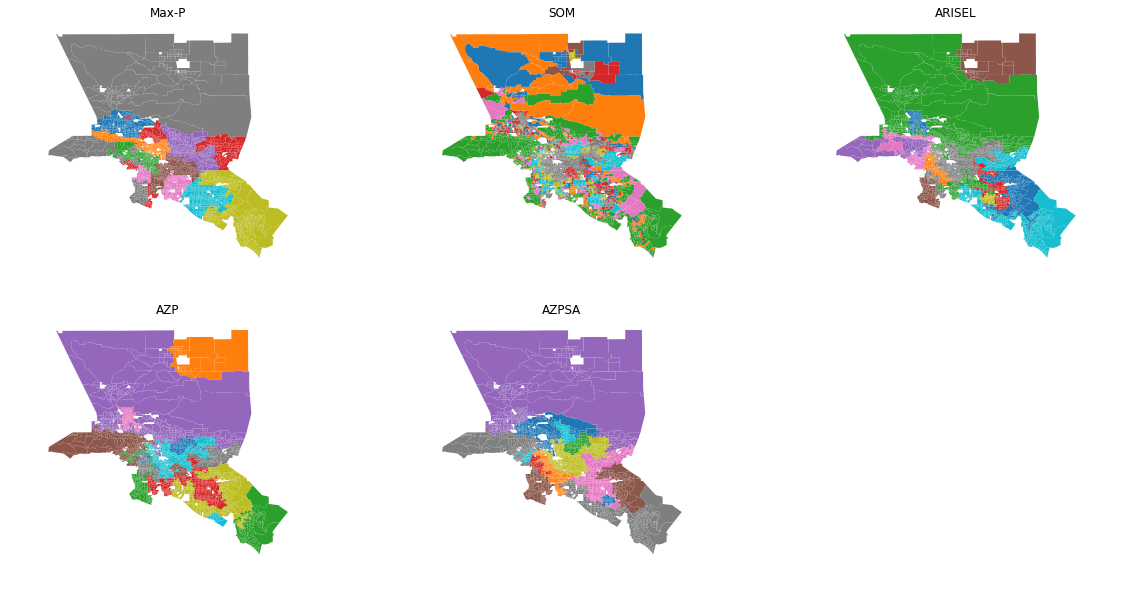

In [95]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, figsize=(20,10))

ax1.set_aspect('equal')
ax1.axis('off')
ax1.set_title("Max-P")

ax2.set_aspect('equal')
ax2.axis('off')
ax2.set_title("SOM")

ax3.set_aspect('equal')
ax3.axis('off')
ax3.set_title("ARISEL")

ax4.set_aspect('equal')
ax4.axis('off')
ax4.set_title("AZP")

ax5.set_aspect('equal')
ax5.axis('off')
ax5.set_title("AZPSA")

ax6.axis('off')


la.reset_index().merge(clusters, left_index=True, right_index=True) \
    .plot(column='maxp', categorical=True, ax=ax1,  )
    

la.reset_index().merge(clusters, left_index=True, right_index=True) \
    .plot(column='som', categorical=True, ax=ax2,  )
    

la.reset_index().merge(clusters, left_index=True, right_index=True) \
    .plot(column='arisel', categorical=True, ax=ax3,  )
    

la.reset_index().merge(clusters, left_index=True, right_index=True) \
    .plot(column='azp', categorical=True, ax=ax4,  )
    

la.reset_index().merge(clusters, left_index=True, right_index=True) \
    .plot(column='azpsa', categorical=True, ax=ax5,  )
